# Malaria parasite detection using ensemble learning in Keras

## Task 1: Loading the cell image data

Ensemble learning combines the predictions of multiple models to improve the prediction accuracy.

There are several ways to perform ensemble learning, and a reasonable summary is available on https://en.wikipedia.org/wiki/Ensemble_learning. Simply speaking, there are two major classes of ensemble learning:
- Bagging: fit independent models and then average their predictions
- Boosting: fit several models sequencially and then average their predictions

In this project we will be using a simplified form of the bagging approach:

- fit a collection of independent models
- gather prediction from each
- apply a voting procedure

Given the predictions from several models, there are two voting procedures
- Hard voting: get the most common class predicted
- Soft voting: get the argmax of the sum of predicted probabilities. It can be either weighted or unweighted.
  - Weighted: each predicted probability is multiplied by a preset weight
  - Unweighted: we don't multiply the predicted probabilities, we just add them straight away

In the interest of time, we will focus on hard voting.

First we import the required libraries: tensorflow, keras, sklearn, cv2, matplotlib, statistics and a few other utilities.

Dataset: https://www.tensorflow.org/datasets/catalog/malaria

In [1]:
!pip3 install keras tensorflow sklearn matplotlib opencv-python pandas

import statistics
import os
import glob
import numpy as np
import pandas as pd
from concurrent import futures
import threading

import tensorflow as tf
from keras.optimizers import SGD, Adam
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

import cv2
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Next, we load the data. 
- File names are obtained using the glob module.
- Create a data frame object for infected and healthy cell images
- Randomize the order of data
- Pick the first 2000 images
- Check how many of each class are there in the sample; we should be close to 50/50

In [4]:
infected='cell_images/Parasitized'
healthy='cell_images/Uninfected'
infected_files=glob.glob(infected+'/*.png')
healthy_files=glob.glob(healthy+'/*.png')
files_df=pd.DataFrame({'img':infected_files+healthy_files,'maleria':[1]*len(infected_files)+[0]*len(healthy_files)})
files_df=files_df.sample(frac=1,random_state=42).reset_index(drop=True)
files_df=files_df.iloc[0:2000,:]
files_df['maleria'].value_counts()

1    1030
0     970
Name: maleria, dtype: int64

In [5]:
infected

'cell_images/Parasitized'

In [6]:
healthy

'cell_images/Uninfected'

In [8]:
infected_files

['cell_images/Parasitized/C175P136NThinF_IMG_20151127_141253_cell_248.png',
 'cell_images/Parasitized/C176P137NThinF_IMG_20151201_120612_cell_27.png',
 'cell_images/Parasitized/C182P143NThinF_IMG_20151201_172607_cell_39.png',
 'cell_images/Parasitized/C137P98ThinF_IMG_20151005_161449_cell_14.png',
 'cell_images/Parasitized/C180P141NThinF_IMG_20151201_170021_cell_21.png',
 'cell_images/Parasitized/C48P9thinF_IMG_20150721_161412_cell_188.png',
 'cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_134712_cell_22.png',
 'cell_images/Parasitized/C184P145ThinF_IMG_20151203_104440_cell_23.png',
 'cell_images/Parasitized/C60P21thinF_IMG_20150804_113602_cell_125.png',
 'cell_images/Parasitized/C182P143NThinF_IMG_20151201_172759_cell_25.png',
 'cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_133350_cell_124.png',
 'cell_images/Parasitized/C164P125ThinF_IMG_20151116_120135_cell_139.png',
 'cell_images/Parasitized/C81P42ThinF_IMG_20150817_120524_cell_191.png',
 'cell_images/Parasitized/C95P56Thi

In [9]:
healthy_files

['cell_images/Uninfected/C72P33_ThinF_IMG_20150815_104843_cell_59.png',
 'cell_images/Uninfected/C125P86ThinF_IMG_20151004_101929_cell_131.png',
 'cell_images/Uninfected/C101P62ThinF_IMG_20150923_170246_cell_7.png',
 'cell_images/Uninfected/C153P114ThinF_IMG_20151115_140242_cell_79.png',
 'cell_images/Uninfected/C112P73ThinF_IMG_20150930_131753_cell_32.png',
 'cell_images/Uninfected/C240ThinF_IMG_20151127_115223_cell_125.png',
 'cell_images/Uninfected/C143P104ThinF_IMG_20151005_230100_cell_88.png',
 'cell_images/Uninfected/C137P98ThinF_IMG_20151005_163901_cell_43.png',
 'cell_images/Uninfected/C169P130ThinF_IMG_20151119_144354_cell_139.png',
 'cell_images/Uninfected/C79P40ThinF_IMG_20150817_103303_cell_91.png',
 'cell_images/Uninfected/C141P102ThinF_IMG_20151005_215348_cell_79.png',
 'cell_images/Uninfected/C213ThinF_IMG_20151106_112422_cell_53.png',
 'cell_images/Uninfected/C208ThinF_IMG_20151029_155411_cell_87.png',
 'cell_images/Uninfected/C136P97ThinF_IMG_20151005_143329_cell_26.pn

In [10]:
files_df

,img,maleria
0,cell_images/Parasitized/C81P42ThinF_IMG_201508...,1
1,cell_images/Parasitized/C182P143NThinF_IMG_201...,1
2,cell_images/Uninfected/C86P47ThinF_IMG_2015082...,0
3,cell_images/Uninfected/C232ThinF_IMG_20151112_...,0
4,cell_images/Uninfected/C132P93ThinF_IMG_201510...,0
...,...,...
1995,cell_images/Parasitized/C56P17thinF_IMG_201507...,1
1996,cell_images/Uninfected/C222ThinF_IMG_20151115_...,0
1997,cell_images/Parasitized/C133P94ThinF_IMG_20151...,1
1998,cell_images/Parasitized/C172P133ThinF_IMG_2015...,1


## Task 2: Transform the image files into arrays and create the datasets

The image files, as they are, are binary. We need to turn them into numbers so we can pass them into the machine learning pipeline.

To do so, we will use the cv2 library to read and resize the images. These operations will be performed by the `get_data()` function.

Next, we place the input arrays into `X` and target values into `y`. We have to normalize the image data by dividing all `X` values by 255, so numbers would range from 0 to 1.

Now that our `X` and `y` are ready, we split the dataset into 80:20 train:test split.

Finally, let's see how the image will look like: use the `imshow()` function in matplotlib, which plots images from 3-d arrays.

cell_images/Parasitized/C81P42ThinF_IMG_20150817_115942_cell_221.png
cell_images/Parasitized/C182P143NThinF_IMG_20151201_172057_cell_180.png
cell_images/Uninfected/C86P47ThinF_IMG_20150820_125057_cell_212.png
cell_images/Uninfected/C232ThinF_IMG_20151112_154424_cell_243.png
cell_images/Uninfected/C132P93ThinF_IMG_20151004_152045_cell_20.png
cell_images/Uninfected/C63P24N_ThinF_IMG_20150818_144456_cell_27.png
cell_images/Parasitized/C136P97ThinF_IMG_20151005_143329_cell_102.png
cell_images/Parasitized/C91P52ThinF_IMG_20150821_124937_cell_216.png
cell_images/Parasitized/C84P45ThinF_IMG_20150818_103817_cell_5.png
cell_images/Parasitized/C181P142ThinF_IMG_20151127_155722_cell_195.png
cell_images/Parasitized/C99P60ThinF_IMG_20150918_141001_cell_96.png
cell_images/Parasitized/C182P143NThinF_IMG_20151201_171836_cell_169.png
cell_images/Uninfected/C152P113ThinF_IMG_20151115_124557_cell_29.png
cell_images/Uninfected/C4thin_original_IMG_20150608_170016_cell_155.png
cell_images/Uninfected/C157P11

cell_images/Parasitized/C59P20thinF_IMG_20150803_112733_cell_168.png
cell_images/Uninfected/C88P49ThinF_IMG_20150820_151451_cell_170.png
cell_images/Parasitized/C180P141NThinF_IMG_20151201_163702_cell_188.png
cell_images/Parasitized/C97P58ThinF_IMG_20150917_151903_cell_2.png
cell_images/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_178.png
cell_images/Uninfected/C208ThinF_IMG_20151029_155827_cell_90.png
cell_images/Parasitized/C137P98ThinF_IMG_20151005_163901_cell_69.png
cell_images/Uninfected/C239ThinF_IMG_20151127_113150_cell_262.png
cell_images/Parasitized/C136P97ThinF_IMG_20151005_140646_cell_122.png
cell_images/Uninfected/C113P74ThinF_IMG_20150930_134429_cell_60.png
cell_images/Uninfected/C56P17thinF_IMG_20150728_160623_cell_53.png
cell_images/Uninfected/C52P13thinF_IMG_20150725_125847_cell_163.png
cell_images/Uninfected/C62P23N_ThinF_IMG_20150818_133055_cell_102.png
cell_images/Uninfected/C177P138NThinF_IMG_20151201_142846_cell_123.png
cell_images/Parasitized/C146P107ThinF_IM

cell_images/Parasitized/C116P77ThinF_IMG_20150930_171954_cell_87.png
cell_images/Uninfected/C108P69ThinF_IMG_20150924_225004_cell_25.png
cell_images/Parasitized/C174P135NThinF_IMG_20151127_135435_cell_202.png
cell_images/Uninfected/C58P19thinF_IMG_20150802_122520_cell_149.png
cell_images/Uninfected/C234ThinF_IMG_20151112_162843_cell_195.png
cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_133447_cell_142.png
cell_images/Uninfected/C56P17thinF_IMG_20150728_160623_cell_20.png
cell_images/Parasitized/C167P128ReThinF_IMG_20151201_105707_cell_236.png
cell_images/Parasitized/C116P77ThinF_IMG_20150930_172112_cell_75.png
cell_images/Uninfected/C185P146ThinF_IMG_20151203_110817_cell_212.png
cell_images/Uninfected/C80P41ThinF_IMG_20150817_111246_cell_9.png
cell_images/Uninfected/C214ThinF_IMG_20151106_115440_cell_75.png
cell_images/Parasitized/C74P35_ThinF_IMG_20150815_113951_cell_128.png
cell_images/Parasitized/C123P84ThinF_IMG_20151002_151143_cell_185.png
cell_images/Uninfected/C109P70ThinF_

cell_images/Parasitized/C62P23N_ThinF_IMG_20150818_133307_cell_168.png
cell_images/Parasitized/C120P81ThinF_IMG_20151002_131120_cell_193.png
cell_images/Parasitized/C46P7ThinF_IMG_20151130_205828_cell_151.png
cell_images/Uninfected/C220ThinF_IMG_20151106_154339_cell_88.png
cell_images/Uninfected/C176P137NThinF_IMG_20151201_120845_cell_52.png
cell_images/Parasitized/C181P142ThinF_IMG_20151127_160650_cell_179.png
cell_images/Parasitized/C92P53ThinF_IMG_20150821_150718_cell_205.png
cell_images/Parasitized/C137P98ThinF_IMG_20151005_163712_cell_81.png
cell_images/Parasitized/C186P147NThinF_IMG_20151203_150557_cell_191.png
cell_images/Parasitized/C158P119ThinF_IMG_20151115_183157_cell_172.png
cell_images/Parasitized/C177P138NThinF_IMG_20151201_142942_cell_167.png
cell_images/Uninfected/C206ThinF_IMG_20151029_141047_cell_173.png
cell_images/Uninfected/C12NThinF_IMG_20150614_124244_cell_64.png
cell_images/Parasitized/C180P141NThinF_IMG_20151201_165528_cell_156.png
cell_images/Parasitized/C181P

cell_images/Uninfected/C79P40ThinF_IMG_20150817_102823_cell_81.png
cell_images/Parasitized/C132P93ThinF_IMG_20151004_152642_cell_38.png
cell_images/Parasitized/C180P141NThinF_IMG_20151201_163751_cell_157.png
cell_images/Uninfected/C73P34_ThinF_IMG_20150815_111114_cell_78.png
cell_images/Parasitized/C184P145ThinF_IMG_20151203_104030_cell_20.png
cell_images/Parasitized/C101P62ThinF_IMG_20150918_151149_cell_70.png
cell_images/Uninfected/C223ThinF_IMG_20151112_103809_cell_171.png
cell_images/Uninfected/C146P107ThinF_IMG_20151018_135846_cell_31.png
cell_images/Uninfected/C64P25N_ThinF_IMG_20150818_153517_cell_24.png
cell_images/Parasitized/C129P90ThinF_IMG_20151004_133538_cell_107.png
cell_images/Uninfected/C63P24N_ThinF_IMG_20150818_143757_cell_110.png
cell_images/Parasitized/C132P93ThinF_IMG_20151004_152642_cell_24.png
cell_images/Parasitized/C157P118ThinF_IMG_20151115_164026_cell_229.png
cell_images/Uninfected/C66P27N_ThinF_IMG_20150818_164008_cell_118.png
cell_images/Uninfected/C226Thin

cell_images/Uninfected/C129P90ThinF_IMG_20151004_133921_cell_25.png
cell_images/Uninfected/C104P65ThinF_IMG_20150918_171751_cell_109.png
cell_images/Uninfected/C165P126ThinF_IMG_20151117_172356_cell_85.png
cell_images/Uninfected/C116P77ThinF_IMG_20150930_171219_cell_21.png
cell_images/Parasitized/C132P93ThinF_IMG_20151004_152642_cell_25.png
cell_images/Uninfected/C182P143NThinF_IMG_20151201_171836_cell_38.png
cell_images/Parasitized/C184P145ThinF_IMG_20151203_102543_cell_157.png
cell_images/Parasitized/C116P77ThinF_IMG_20150930_172112_cell_98.png
cell_images/Uninfected/C216ThinF_IMG_20151106_135337_cell_48.png
cell_images/Uninfected/C185P146ThinF_IMG_20151203_110933_cell_85.png
cell_images/Parasitized/C82P43ThinF_IMG_20150817_125326_cell_9.png
cell_images/Parasitized/C137P98ThinF_IMG_20151005_160918_cell_71.png
cell_images/Uninfected/C203ThinF_IMG_20151029_104112_cell_29.png
cell_images/Parasitized/C77P38ThinF_IMG_20150602_143524_cell_150.png
cell_images/Parasitized/C180P141NThinF_IMG_

cell_images/Parasitized/C140P101ThinF_IMG_20151005_210309_cell_182.png
cell_images/Uninfected/C91P52ThinF_IMG_20150821_124739_cell_165.png
cell_images/Uninfected/C213ThinF_IMG_20151106_112603_cell_155.png
cell_images/Uninfected/C224ThinF_IMG_20151112_112735_cell_179.png
cell_images/Parasitized/C137P98ThinF_IMG_20151005_164119_cell_65.png
cell_images/Uninfected/C66P27N_ThinF_IMG_20150818_163419_cell_127.png
cell_images/Parasitized/C117P78ThinF_IMG_20150930_214317_cell_105.png
cell_images/Parasitized/C136P97ThinF_IMG_20151005_140538_cell_113.png
cell_images/Uninfected/C133P94ThinF_IMG_20151004_155518_cell_14.png
cell_images/Parasitized/C76P37ThinF_IMG_20150815_172902_cell_222.png
cell_images/Parasitized/C124P85ThinF_IMG_20151002_154846_cell_147.png
cell_images/Uninfected/C180P141NThinF_IMG_20151201_164714_cell_101.png
cell_images/Parasitized/C179P140ThinF_IMG_20151127_153819_cell_176.png
cell_images/Parasitized/C132P93ThinF_IMG_20151004_152642_cell_41.png
cell_images/Uninfected/C203ThinF

cell_images/Parasitized/C48P9thinF_IMG_20150721_160406_cell_243.png
cell_images/Parasitized/C188P149ThinF_IMG_20151203_134419_cell_199.png
cell_images/Parasitized/C184P145ThinF_IMG_20151203_104030_cell_40.png
cell_images/Parasitized/C182P143NThinF_IMG_20151201_171836_cell_175.png
cell_images/Parasitized/C182P143NThinF_IMG_20151201_172607_cell_11.png
cell_images/Parasitized/C132P93ThinF_IMG_20151004_152257_cell_152.png
cell_images/Parasitized/C103P64ThinF_IMG_20150918_165125_cell_165.png
cell_images/Parasitized/C184P145ThinF_IMG_20151203_104030_cell_21.png
cell_images/Parasitized/C70P31_ThinF_IMG_20150813_131022_cell_94.png
cell_images/Parasitized/C99P60ThinF_IMG_20150918_141351_cell_138.png
cell_images/Parasitized/C128P89ThinF_IMG_20151004_131753_cell_137.png
cell_images/Uninfected/C55P16thinF_IMG_20150728_123154_cell_122.png
cell_images/Parasitized/C132P93ThinF_IMG_20151004_151941_cell_30.png
cell_images/Parasitized/C91P52ThinF_IMG_20150821_124311_cell_4.png
cell_images/Uninfected/C88

cell_images/Uninfected/C110P71ThinF_IMG_20150930_105559_cell_186.png
cell_images/Parasitized/C118P79ThinF_IMG_20151002_105827_cell_153.png
cell_images/Uninfected/C37BP2_thinF_IMG_20150620_133001a_cell_45.png
cell_images/Uninfected/C185P146ThinF_IMG_20151203_110448_cell_245.png
cell_images/Parasitized/C189P150ThinF_IMG_20151203_141719_cell_55.png
cell_images/Uninfected/C3thin_original_IMG_20150608_162835_cell_77.png
cell_images/Parasitized/C180P141NThinF_IMG_20151201_165453_cell_29.png
cell_images/Uninfected/C3thin_original_IMG_20150608_163029_cell_220.png
cell_images/Parasitized/C184P145ThinF_IMG_20151203_103637_cell_185.png
cell_images/Parasitized/C182P143NThinF_IMG_20151201_171950_cell_172.png
cell_images/Parasitized/C80P41ThinF_IMG_20150817_111802_cell_17.png
cell_images/Uninfected/C223ThinF_IMG_20151112_104410_cell_30.png
cell_images/Uninfected/C170P131ThinF_IMG_20151119_120111_cell_56.png
cell_images/Uninfected/C131P92ThinF_IMG_20151004_151126_cell_58.png
cell_images/Parasitized/C

cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_134712_cell_35.png
cell_images/Parasitized/C99P60ThinF_IMG_20150918_141857_cell_15.png
cell_images/Uninfected/C39P4thinF_original_IMG_20150622_110435_cell_32.png
cell_images/Parasitized/C70P31_ThinF_IMG_20150819_142703_cell_17.png
cell_images/Uninfected/C203ThinF_IMG_20151029_104112_cell_28.png
cell_images/Uninfected/C97P58ThinF_IMG_20150917_151512_cell_16.png
cell_images/Parasitized/C184P145ThinF_IMG_20151203_104153_cell_165.png
cell_images/Parasitized/C47P8thin_Original_Motic_IMG_20150714_093512_cell_171.png
cell_images/Uninfected/C37BP2_thinF_IMG_20150620_133238a_cell_83.png
cell_images/Uninfected/C208ThinF_IMG_20151029_151017_cell_175.png
cell_images/Uninfected/C201ThinF_IMG_20150930_143129_cell_99.png
cell_images/Uninfected/C157P118ThinF_IMG_20151115_163611_cell_131.png
cell_images/Uninfected/C180P141NThinF_IMG_20151201_165528_cell_21.png
cell_images/Parasitized/C39P4thinF_original_IMG_20150622_113632_cell_33.png
cell_images/Uninf

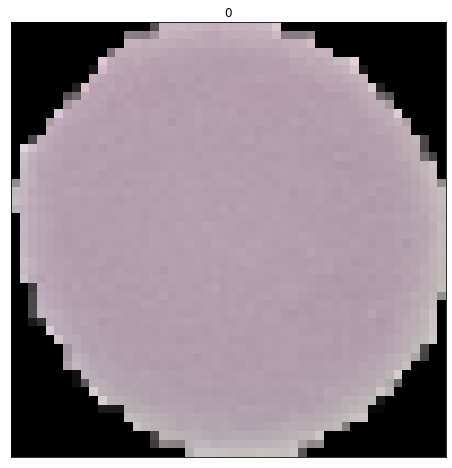

In [19]:
img_length,img_width=50,50
def get_data(data_files):
    data= []
    for img in data_files:
        print(img)
        img=cv2.imread(img)
        img=cv2.resize(img,dsize=(img_length,img_width),interpolation=cv2.INTER_CUBIC)
        img=np.array(img)
        data+=[img]
    return np.array(data)
X= files_df['img'].values
y= files_df['maleria'].values
X_converted=get_data(X)/255.0
train_data, val_data, train_labels, val_labels= train_test_split(X_converted,y,test_size=0.2,random_state=42)
plt.figure(figsize=(8,8))
plt.imshow(train_data[0])
plt.title('{}'.format(train_labels[0]))
plt.xticks([])
plt.yticks([])
plt.savefig('sample')

## Task 3: Create a deep CNN

Time to start doing deep learning to predict the presence or absence of malaria in cell images.

We will be experimenting with a deep convolutional neural network which has the following architecture:

- two 32 convolutional layers, each followed by max pooling
- 64 convolutional layer, followed by max pooling
- layer flattening
- a dense hidden layer with 64 nodes
- dropping 50% of the prev hidden layer
- output layer with 1 node

The Adam optimizer will be used with a learning rate of 0.001.

In [20]:
model=Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(img_length,img_width,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

adam=Adam(lr=.001)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

## Task 4: Train and test the CNN

Next, we call the fit method to optimize the model in 25 epochs, then perform prediction using the predict_classes method.

We measure our prediction accuracy using the classification_report function, which gives us the key classification metrics. I will also display those metrics individually so you can know their formulas.

- Precision: ability of the classifier not to label as positive a sample that is negative.
- Recall: the ability of the classifier to find all the positive samples
- f1: weighted average of the precision and recall

In additioin:
- Accuracy: measures how close the predicions are to the actual values

Using the history object, we plot the validation accuracy and loss across the epochs to see how our models coverged.

In [ ]:

# accuracy = (true positives + true negatives) / (positives + negatives)

# precision = true positives / (true positives + false positives)

# recall = true positives / (true positives + false negatives)

# f1 = 2 * (precision * recall) / (precision + recall)




## Task 5: Create the CNN models ensemble

Now that we know we can achieve good accuracy with one CN model, let's try an ensemble of CNN models. Let's generate an ensemble of 2 more models using a formula, as in this code.

Here we create the models and place them in a dictionary of models, `models`.

Epoch 1/25
25/25 [==============================] - 3s 135ms/step - loss: 0.6840 - accuracy: 0.5587 - val_loss: 0.6733 - val_accuracy: 0.6375
Epoch 2/25
25/25 [==============================] - 3s 110ms/step - loss: 0.6691 - accuracy: 0.6044 - val_loss: 0.6528 - val_accuracy: 0.6600
Epoch 3/25
25/25 [==============================] - 3s 102ms/step - loss: 0.6451 - accuracy: 0.6431 - val_loss: 0.6387 - val_accuracy: 0.6675
Epoch 4/25
25/25 [==============================] - 2s 100ms/step - loss: 0.6241 - accuracy: 0.6719 - val_loss: 0.6322 - val_accuracy: 0.6400
Epoch 5/25
25/25 [==============================] - 2s 98ms/step - loss: 0.6068 - accuracy: 0.6856 - val_loss: 0.6026 - val_accuracy: 0.6975
Epoch 6/25
25/25 [==============================] - 2s 100ms/step - loss: 0.5920 - accuracy: 0.7050 - val_loss: 0.5861 - val_accuracy: 0.7075
Epoch 7/25
25/25 [==============================] - 2s 96ms/step - loss: 0.5879 - accuracy: 0.7056 - val_loss: 0.5896 - val_accuracy: 0.7000
Epoch 8/

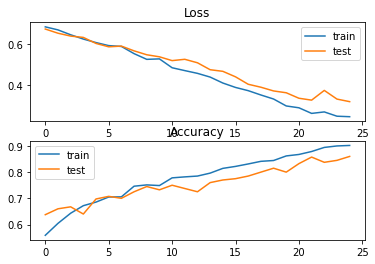

In [21]:
history= model.fit(x=train_data,y=train_labels,batch_size=64,epochs=25,verbose=1,shuffle=True,validation_data=(val_data,val_labels))
y_predicted=model.predict_classes(val_data)

print('accuracy=', accuracy_score(val_labels,y_predicted))

print("precision=",precision_score(val_labels,y_predicted))

print("recall=",recall_score(val_labels,y_predicted))

print("f1=",f1_score(val_labels,y_predicted))

print(classification_report(val_labels,y_predicted))

plt.subplot(211)
plt.title("Loss")
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.savefig('accuracy_loss')

## Task 6: Fit the models in the ensemble and perform the prediction

Next, we fit each of the models separately using the same datasets.

Once done, we generate the predictions and add them into an array, `predictions_hard`.

In [30]:
models={}
for j in range(2,4):
    newmodel=Sequential()
    newmodel.add(Conv2D(16*j,(3,3),activation='relu',input_shape=(img_length,img_width,3)))
    newmodel.add(MaxPooling2D(pool_size=(2,2)))
    newmodel.add(Conv2D(16*j,(3,3),activation='relu'))
    newmodel.add(MaxPooling2D(pool_size=(2,2)))
    newmodel.add(Conv2D(32*j,(3,3),activation='relu'))
    newmodel.add(MaxPooling2D(pool_size=(2,2)))
    newmodel.add(Flatten())
    newmodel.add(Dense(32*j,activation='relu'))
    newmodel.add(Dropout(0.5))
    newmodel.add(Dense(1,activation='sigmoid'))
    newmodel.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
    models[j]=newmodel
models[1]=model

In [33]:
del models[1]
for j in models:
    models[j].fit(x=train_data, y=train_labels, batch_size=64,epochs=25,verbose=1, shuffle=True,validation_data=(val_data,val_labels))
    
    
models[1]=model
predictions_hard=[]
for j in models:
    predictions_hard+= [models[j].predict_classes(val_data)]

Epoch 1/25
25/25 [==============================] - 4s 153ms/step - loss: 0.0749 - accuracy: 0.9762 - val_loss: 0.3678 - val_accuracy: 0.8900
Epoch 2/25
25/25 [==============================] - 4s 142ms/step - loss: 0.0748 - accuracy: 0.9800 - val_loss: 0.3917 - val_accuracy: 0.8875
Epoch 3/25
25/25 [==============================] - 3s 139ms/step - loss: 0.0767 - accuracy: 0.9750 - val_loss: 0.3221 - val_accuracy: 0.9100
Epoch 4/25
25/25 [==============================] - 3s 139ms/step - loss: 0.0500 - accuracy: 0.9869 - val_loss: 0.3707 - val_accuracy: 0.8850
Epoch 5/25
25/25 [==============================] - 3s 138ms/step - loss: 0.0412 - accuracy: 0.9881 - val_loss: 0.3724 - val_accuracy: 0.9000
Epoch 6/25
25/25 [==============================] - 3s 139ms/step - loss: 0.0410 - accuracy: 0.9875 - val_loss: 0.4277 - val_accuracy: 0.8900
Epoch 7/25
25/25 [==============================] - 3s 139ms/step - loss: 0.0330 - accuracy: 0.9875 - val_loss: 0.4517 - val_accuracy: 0.8875
Epoch 

## Task 7: Apply hard voting to the ensemble

Here we will apply the hard voting procedure. This is by deciding the class according the majority vote. We will use the `mode()` statistical function to get the class that was predicted more frequently than the other.

Remember that the mean function gives you the data value that was repeated the most in the dataset. So in our predicted classes, where there are only 1's and 0's, it will pick the value that was repeated most frequently.

In [34]:
voting_hard=[]
for i in range(0,len(val_data)):
    voting_hard+=[statistics.mode([predictions_hard[0][i][0],predictions_hard[1][i][0,predictions_hard[2][i][0])]
                                   
print(classification_report(val_labels,voting_hard))                   

SyntaxError: invalid syntax (<ipython-input-34-a3595627138d>, line 3)

In [35]:
!pwd

/home/rhyme/Desktop/Project
